In [1]:
!pip install pandas


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import pandas as pd

# Load the data from CSV file
df = pd.read_csv("original_session_level_data.csv")

# Count session types for each class
session_counts = df.groupby(['class', 'class_session_type']).size().unstack(fill_value=0)

# Calculate the required sums
session_counts['total_classwork_indep'] = session_counts.get('classwork', 0) + session_counts.get('at school independent work', 0)
session_counts['homework_greater'] = session_counts.get('homework', 0) > session_counts['total_classwork_indep']

# Filter classes where homework > (classwork + at school indep)
result_classes = session_counts[session_counts['homework_greater']].index.tolist()

# Display results
print("Classes where homework count > (classwork + at school independent work):")
if len(result_classes) == 0: print("no such classes")
for class_id in result_classes:
    print(class_id)

# Optional: Display the counts for verification
print("\nSession type counts per class:")
print(session_counts[['classwork', 'at school independent work', 'homework', 'total_classwork_indep']])

Classes where homework count > (classwork + at school independent work):
no such classes

Session type counts per class:
class_session_type  classwork  at school independent work  homework  \
class                                                                 
c1                         59                         123         9   
c10                       694                         125        53   
c11                       373                          55        50   
c12                      1164                         115       141   
c13                       590                         292        86   
c14                       303                         191        11   
c15                       694                         210       103   
c2                       1224                         132       147   
c3                        549                         139         3   
c4                        161                          47        18   
c5                        9

/var/folders/bh/d4vzbc194yxb1c729qdk9r940000gn/T/ipykernel_60045/4175053655.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['session_label'] = filtered_df['class_session_type'].map(session_mapping)



Class c1 - Session Counts Outside 7AM-4PM:
Classwork: 0 sessions
Independent Study: 0 sessions

Class c10 - Session Counts Outside 7AM-4PM:
Classwork: 0 sessions
Independent Study: 14 sessions

Class c11 - Session Counts Outside 7AM-4PM:
Classwork: 0 sessions
Independent Study: 3 sessions

Class c12 - Session Counts Outside 7AM-4PM:
Classwork: 0 sessions
Independent Study: 16 sessions

Class c13 - Session Counts Outside 7AM-4PM:
Classwork: 0 sessions
Independent Study: 21 sessions

Class c14 - Session Counts Outside 7AM-4PM:
Classwork: 0 sessions
Independent Study: 13 sessions

Class c15 - Session Counts Outside 7AM-4PM:
Classwork: 0 sessions
Independent Study: 4 sessions

Class c2 - Session Counts Outside 7AM-4PM:
Classwork: 0 sessions
Independent Study: 19 sessions

Class c3 - Session Counts Outside 7AM-4PM:
Classwork: 0 sessions
Independent Study: 1 sessions

Class c4 - Session Counts Outside 7AM-4PM:
Classwork: 0 sessions
Independent Study: 0 sessions

Class c5 - Session Counts Ou

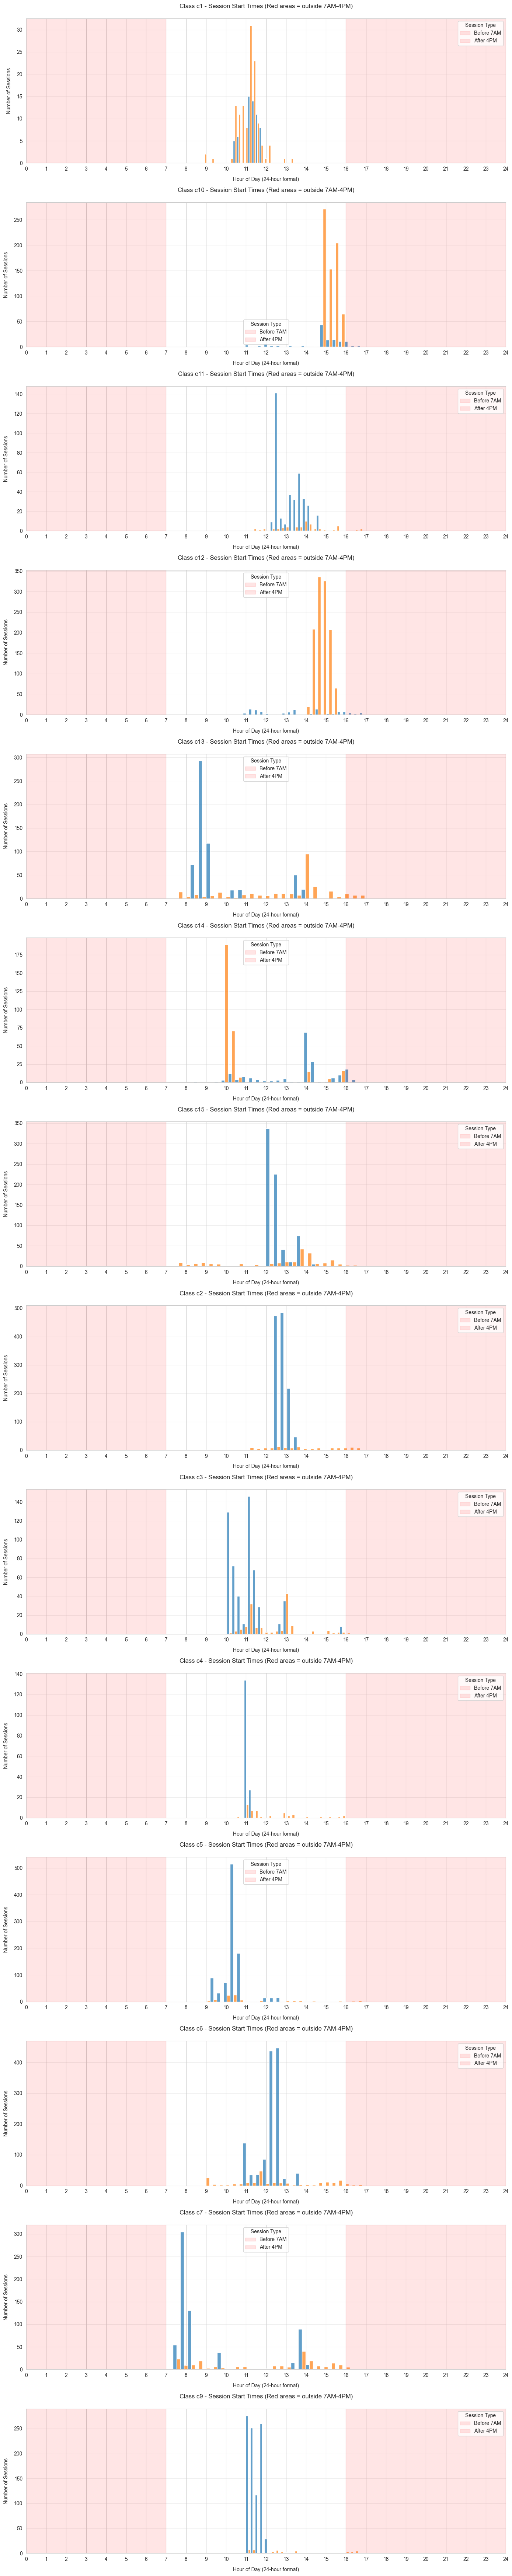

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare data
df = pd.read_csv("original_session_level_data.csv")
df['start_time'] = pd.to_datetime(df['class_session_start_time'], format='%Y-%m-%d %H:%M:%S')
df['start_hour'] = df['start_time'].dt.hour + df['start_time'].dt.minute/60

# Filter and label session types
session_mapping = {
    'classwork': 'Classwork',
    'at school independent work': 'Independent Study'
}
filtered_df = df[df['class_session_type'].isin(session_mapping.keys())]
filtered_df['session_label'] = filtered_df['class_session_type'].map(session_mapping)

# Create plots and analyze out-of-hours sessions
classes = filtered_df['class'].unique()
plt.figure(figsize=(14, 5*len(classes)))
sns.set_style("whitegrid")

for i, class_id in enumerate(classes, 1):
    class_data = filtered_df[filtered_df['class'] == class_id]
    
    # --- Analysis ---
    print(f"\nClass {class_id} - Session Counts Outside 7AM-4PM:")
    for session_type in ['Classwork', 'Independent Study']:
        # Count sessions before 7AM or after 4PM
        out_of_hours = class_data[
            (class_data['session_label'] == session_type) & 
            ((class_data['start_hour'] < 7) | (class_data['start_hour'] > 16))
        ]
        print(f"{session_type}: {len(out_of_hours)} sessions")
    
    # --- Visualization ---
    plt.subplot(len(classes), 1, i)
    
    # Main histogram (7AM-4PM)
    sns.histplot(
        data=class_data,
        x='start_hour',
        hue='session_label',
        bins=24,
        multiple='dodge',
        palette=['#1f77b4', '#ff7f0e'],
        alpha=0.7,
        edgecolor='white'
    )
    
    # Highlight out-of-hours area
    plt.axvspan(0, 7, color='red', alpha=0.1, label='Before 7AM')
    plt.axvspan(16, 24, color='red', alpha=0.1, label='After 4PM')
    
    plt.title(f'Class {class_id} - Session Start Times (Red areas = outside 7AM-4PM)', pad=20)
    plt.xlabel('Hour of Day (24-hour format)', labelpad=10)
    plt.ylabel('Number of Sessions', labelpad=10)
    plt.xlim(0, 24)
    plt.xticks(range(0, 25, 1))
    plt.grid(axis='y', alpha=0.3)
    plt.legend(title='Session Type')

plt.tight_layout()
plt.show()

In [1]:
import pandas as pd

# Load both datasets
session_df = pd.read_csv("original_session_level_data.csv")
livelab_df = pd.read_csv("LiveLab_with_Gaming.csv")

# Convert all time columns to datetime
session_df['class_session_start_time'] = pd.to_datetime(session_df['class_session_start_time'])
session_df['class_session_end_time'] = pd.to_datetime(session_df['class_session_end_time'])
livelab_df['Time'] = pd.to_datetime(livelab_df['Time'])

# Filter for only helped transactions in livelab
helped_transactions = livelab_df[livelab_df['helpedTransaction'] == True]

# Initialize new column
session_df['helpedSession'] = False

# Iterate through each student session
for idx, session in session_df.iterrows():
    # Find matching helped transactions
    matches = helped_transactions[
        (helped_transactions['Anon Student Id'] == session['anon_student_id']) &
        (helped_transactions['cf_class_id'] == session['class']) &
        (helped_transactions['Time'] >= session['class_session_start_time']) &
        (helped_transactions['Time'] <= session['class_session_end_time'])
    ]
    
    # Mark session if any matches found
    if len(matches) > 0:
        session_df.at[idx, 'helpedSession'] = True

# Save the updated session data
# session_df.to_csv("session_level_data_with_help.csv", index=False)

# Print summary statistics
print(f"Total sessions: {len(session_df)}")
print(f"Sessions with help: {session_df['helpedSession'].sum()}")

# Optional: Breakdown by session type
if 'class_session_type' in session_df.columns:
    print("\nHelp by session type:")
    print(session_df.groupby('class_session_type')['helpedSession'].agg(['sum', 'count', 'mean']))

Total sessions: 12542
Sessions with help: 7

Help by session type:
                            sum  count      mean
class_session_type                              
at school independent work    1   2024  0.000494
classwork                     6   9565  0.000627
homework                      0    953  0.000000


In [1]:
import pandas as pd

# Load both datasets
session_df = pd.read_csv("original_session_level_data.csv")
livelab_df = pd.read_csv("LiveLab_with_Gaming.csv")

# Convert all time columns to datetime
time_format = '%Y-%m-%d %H:%M:%S'  # Adjust if your format differs
session_df['class_session_start_time'] = pd.to_datetime(session_df['class_session_start_time'], format=time_format)
session_df['class_session_end_time'] = pd.to_datetime(session_df['class_session_end_time'], format=time_format)
livelab_df['Time'] = pd.to_datetime(livelab_df['Time'], format=time_format)

# Filter for only helped transactions in livelab
helped_transactions = livelab_df[livelab_df['helpedTransaction'] == True]

# Initialize new columns
session_df['helpedSession'] = False
session_df['help_count'] = 0  # Will count helped transactions per session

# Create index for faster lookups
session_df['temp_index'] = session_df.index

# Iterate through each helped transaction to find matching sessions
for _, transaction in helped_transactions.iterrows():
    # Find matching sessions
    matching_sessions = session_df[
        (session_df['anon_student_id'] == transaction['Anon Student Id']) &
        (session_df['class'] == transaction['cf_class_id']) &
        (session_df['class_session_start_time'] <= transaction['Time']) &
        (session_df['class_session_end_time'] >= transaction['Time'])
    ]
    
    # Update matching sessions
    for idx in matching_sessions['temp_index']:
        session_df.at[idx, 'helpedSession'] = True
        session_df.at[idx, 'help_count'] += 1

# Remove temporary index column
session_df.drop('temp_index', axis=1, inplace=True)

# Save the enhanced session data
# output_filename = "session_level_data_with_help_counts.csv"
# session_df.to_csv(output_filename, index=False)

# Generate comprehensive report
print("\n=== Session Help Analysis ===")
print(f"Total sessions analyzed: {len(session_df)}")
print(f"Sessions that received help: {session_df['helpedSession'].sum()}")
print(f"Total helped transactions matched: {session_df['help_count'].sum()}\n")

# Detailed breakdown
if 'class_session_type' in session_df.columns:
    print("Help distribution by session type:")
    help_by_type = session_df.groupby('class_session_type').agg(
        total_sessions=('helpedSession', 'count'),
        helped_sessions=('helpedSession', 'sum'),
        total_help=('help_count', 'sum')
    )
    help_by_type['help_per_session'] = help_by_type['total_help'] / help_by_type['helped_sessions']
    print(help_by_type.round(2))

# Show sessions with most help
print("\nTop 10 sessions with most help received:")
print(session_df.nlargest(10, 'help_count')[['anon_student_id', 'class', 'student_session_start_time', 'help_count']])


=== Session Help Analysis ===
Total sessions analyzed: 12542
Sessions that received help: 7
Total helped transactions matched: 68

Help distribution by session type:
                            total_sessions  helped_sessions  total_help  \
class_session_type                                                        
at school independent work            2024                1          32   
classwork                             9565                6          36   
homework                               953                0           0   

                            help_per_session  
class_session_type                            
at school independent work              32.0  
classwork                                6.0  
homework                                 NaN  

Top 10 sessions with most help received:
     anon_student_id class student_session_start_time  help_count
4279             s70   c14        2022-11-04 14:08:57          32
3357              s6   c13        2023-01-23 13:

Helped Transactions Outside 7AM-4PM by Class:
c15: 291 interventions (84.6%)
c11: 344 interventions (100.0%)
c7: 0 interventions (0.0%)
c14: 23 interventions (7.6%)
c13: 0 interventions (0.0%)
c4: 255 interventions (100.0%)
c3: 179 interventions (82.5%)
c10: 206 interventions (100.0%)
c5: 28 interventions (15.1%)
c12: 165 interventions (100.0%)
c9: 115 interventions (70.6%)
c6: 139 interventions (96.5%)
c2: 106 interventions (100.0%)
c1: 4 interventions (10.5%)


/var/folders/bh/d4vzbc194yxb1c729qdk9r940000gn/T/ipykernel_69718/1516586422.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=class_data, x='time_bin',
/var/folders/bh/d4vzbc194yxb1c729qdk9r940000gn/T/ipykernel_69718/1516586422.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=class_data, x='time_bin',
/var/folders/bh/d4vzbc194yxb1c729qdk9r940000gn/T/ipykernel_69718/1516586422.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=class_data, x='time_bin',
/var/folders/bh/d4vzbc194yxb1c729qdk9r940000gn/T/ipykernel_69

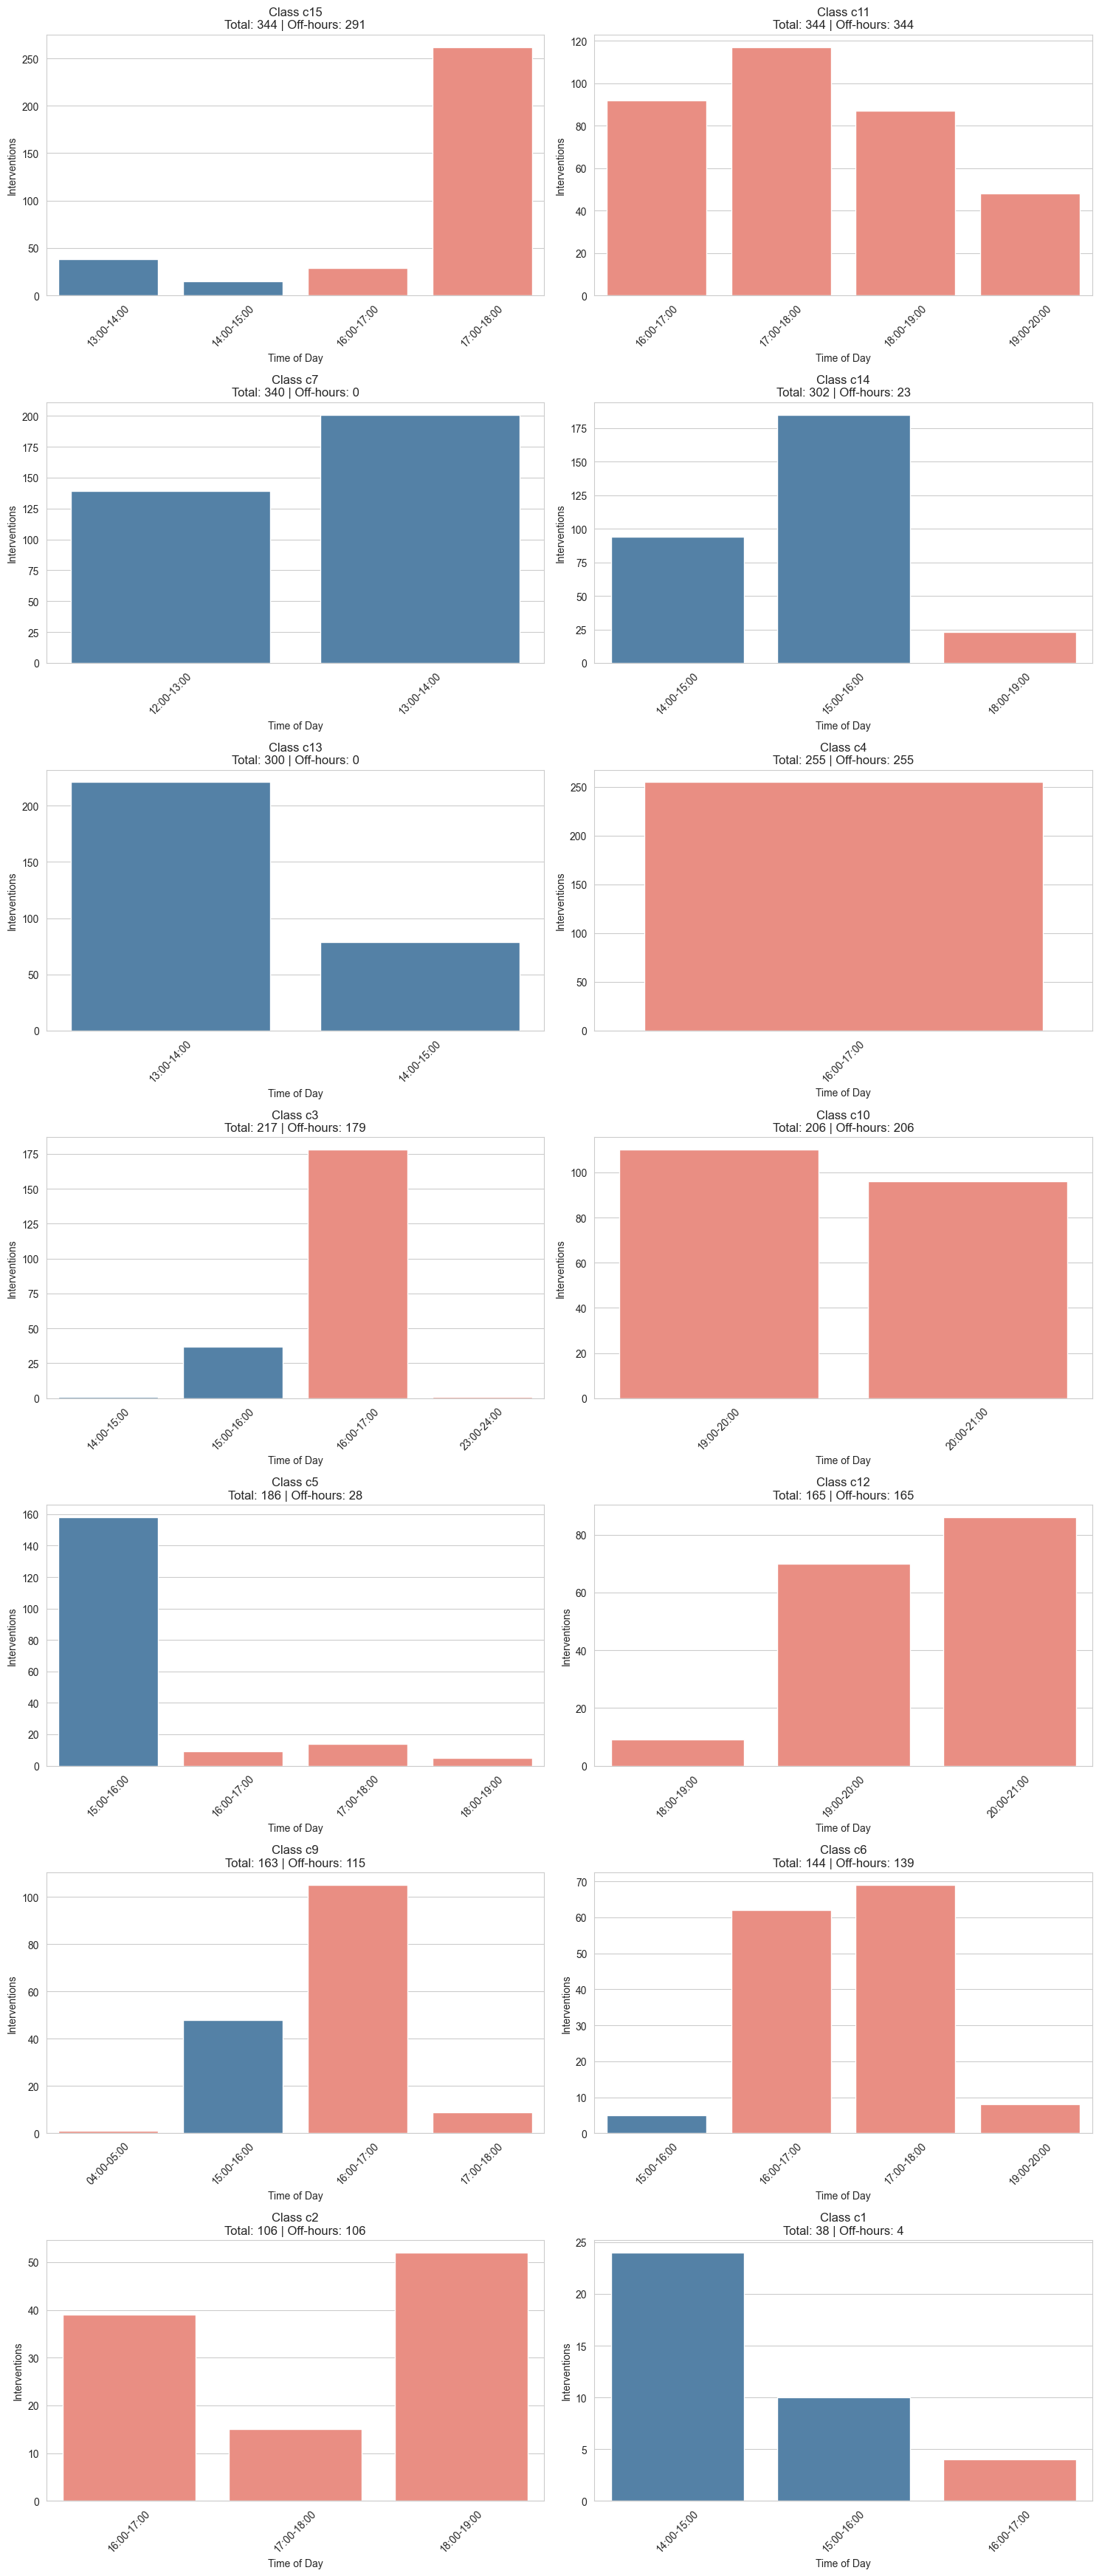

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
livelab = pd.read_csv("LiveLab_with_Gaming.csv")
sessions = pd.read_csv("original_session_level_data.csv")

# Process helped transactions
helped = livelab[livelab['helpedTransaction'] == True].copy()
helped['Time'] = pd.to_datetime(helped['Time'])

# Create student->class mapping
class_map = sessions.drop_duplicates('anon_student_id', keep='last') \
                   .set_index('anon_student_id')['class'] \
                   .to_dict()

# Map classes and clean data
helped['class_id'] = helped['Anon Student Id'].map(class_map)
helped = helped.dropna(subset=['class_id']).copy()

# Extract hour and create time bins
helped['hour'] = helped['Time'].dt.hour
helped['time_bin'] = helped['hour'].apply(lambda x: f"{x:02d}:00-{x+1:02d}:00")

# Calculate off-hours interventions (before 7AM or after 4PM)
helped['off_hours'] = (helped['hour'] < 7) | (helped['hour'] >= 16)

# Get classes sorted by intervention count
class_counts = helped['class_id'].value_counts()
classes = class_counts.index.tolist()

# Print off-hours counts for each class
print("Helped Transactions Outside 7AM-4PM by Class:")
for class_id in classes:
    class_data = helped[helped['class_id'] == class_id]
    off_hours_count = class_data['off_hours'].sum()
    print(f"{class_id}: {off_hours_count} interventions ({off_hours_count/len(class_data):.1%})")

# Plot settings
n_cols = 2
n_rows = (len(classes) + n_cols - 1) // n_cols
plt.figure(figsize=(15, 5 * n_rows))
sns.set_style("whitegrid")

for idx, class_id in enumerate(classes):
    plt.subplot(n_rows, n_cols, idx + 1)
    class_data = helped[helped['class_id'] == class_id]
    
    # Create color mapping
    time_bins = sorted(class_data['time_bin'].unique())
    colors = ['salmon' if (int(bin[:2]) < 7 or int(bin[:2]) >= 16) else 'steelblue' for bin in time_bins]
    
    # Create plot
    sns.countplot(data=class_data, x='time_bin', 
                 order=time_bins,
                 palette=colors)
    
    plt.title(f'Class {class_id}\nTotal: {len(class_data)} | Off-hours: {class_data["off_hours"].sum()}')
    plt.xlabel('Time of Day')
    plt.ylabel('Interventions')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Total transactions in livelab: 1,642,145

Unmatched transactions (no class found): 213,194 (13.0%)
These student IDs weren't found in session data:
['s141' 's295' 's184' 's124' 's16' 's246' 's161' 's337' 's122' 's68'
 's120' 's166' 's171' 's44' 's310' 's172' 's14' 's167' 's174']

Matched transactions: 1,428,951 (should match your expected count minus unmatched)


/var/folders/bh/d4vzbc194yxb1c729qdk9r940000gn/T/ipykernel_71707/2048601861.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=class_data, x='time_bin',
/var/folders/bh/d4vzbc194yxb1c729qdk9r940000gn/T/ipykernel_71707/2048601861.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=class_data, x='time_bin',
/var/folders/bh/d4vzbc194yxb1c729qdk9r940000gn/T/ipykernel_71707/2048601861.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=class_data, x='time_bin',
/var/folders/bh/d4vzbc194yxb1c729qdk9r940000gn/T/ipykernel_71

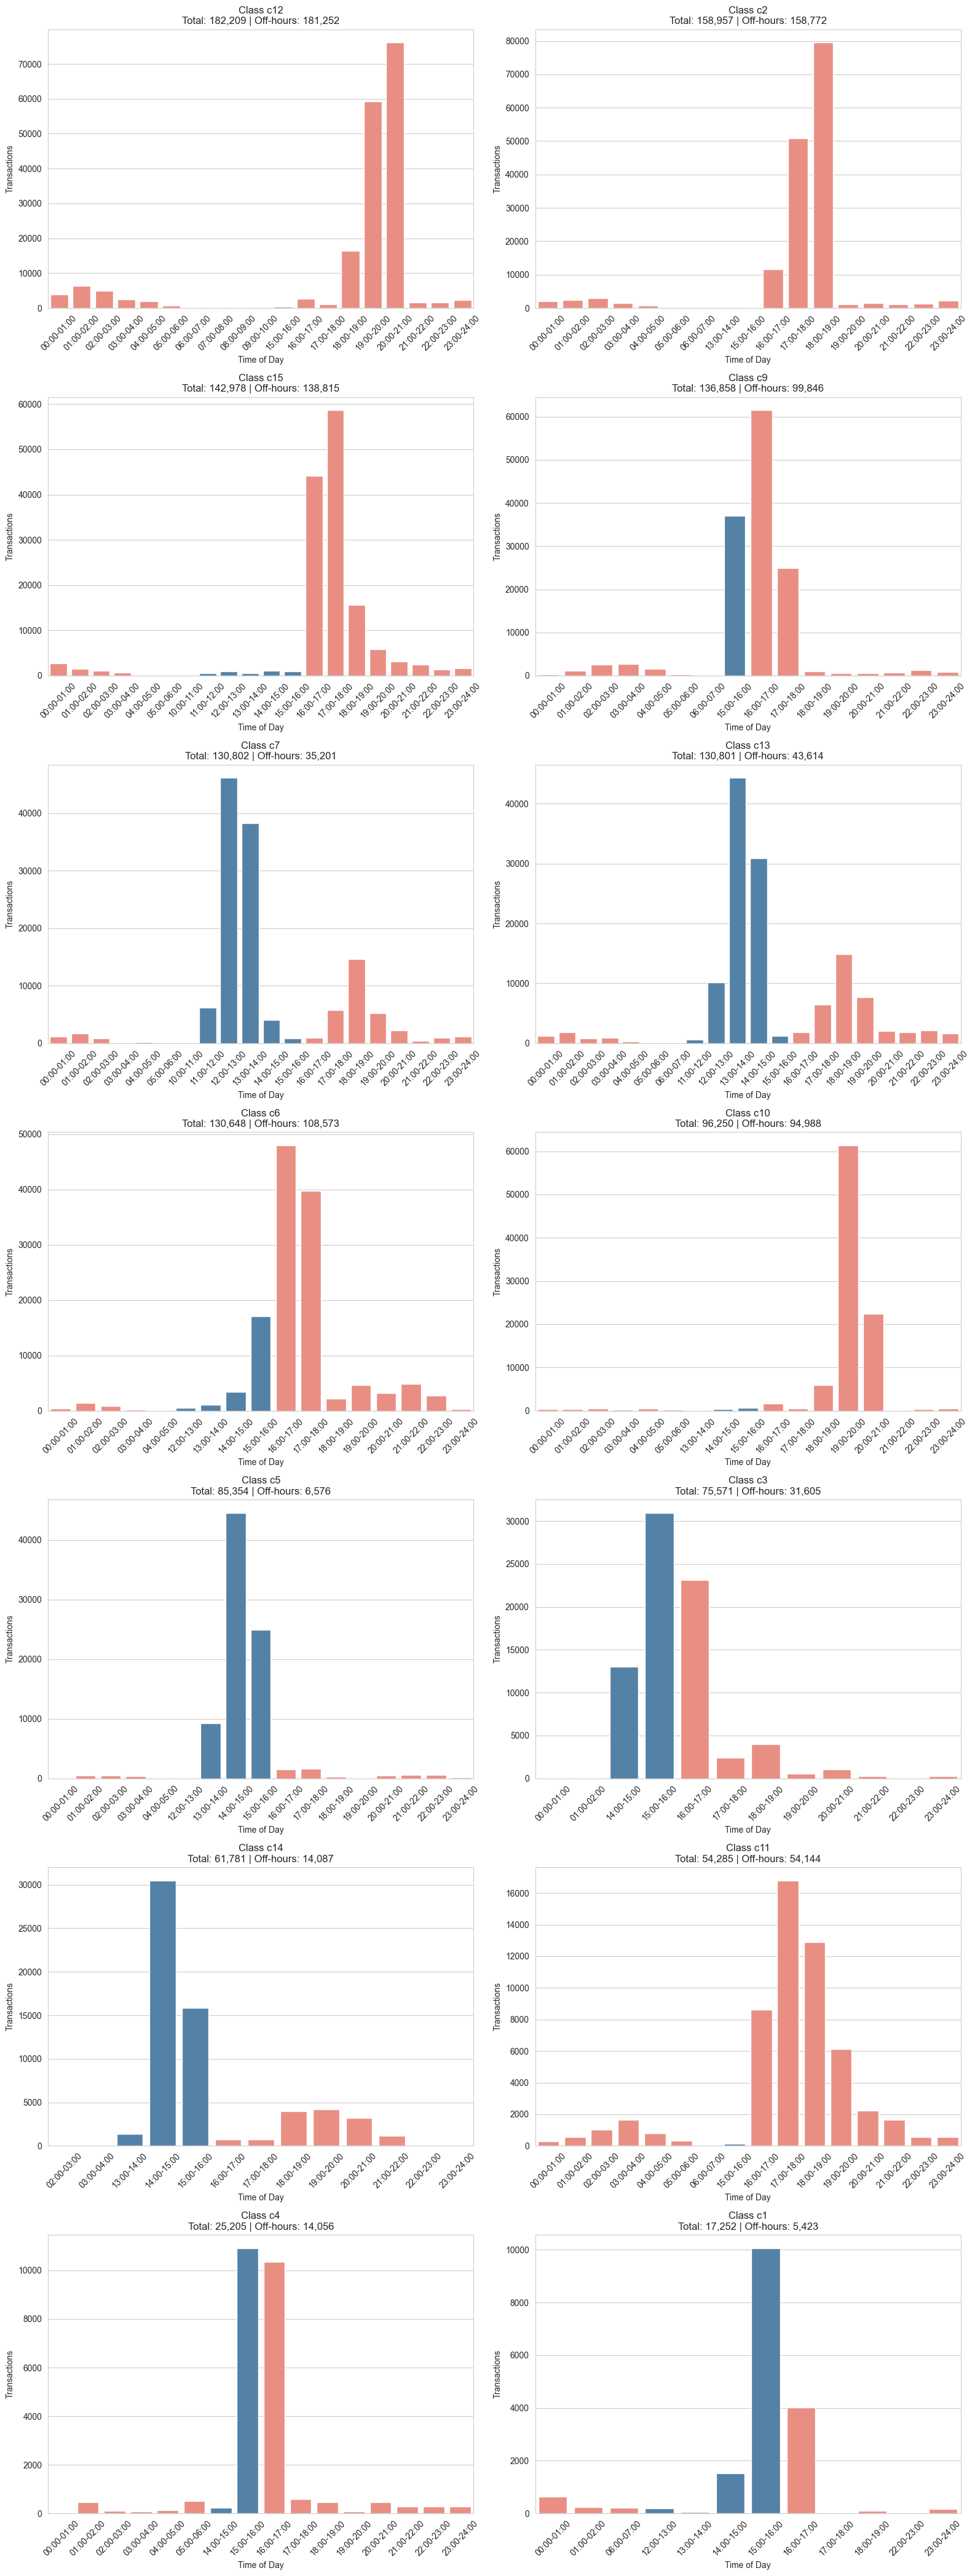


Class distribution of transactions:
class_id
c12    182209
c2     158957
c15    142978
c9     136858
c7     130802
c13    130801
c6     130648
c10     96250
c5      85354
c3      75571


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
livelab = pd.read_csv("LiveLab_with_Gaming.csv")
sessions = pd.read_csv("original_session_level_data.csv")

# Verify raw transaction count
print(f"Total transactions in livelab: {len(livelab):,}")

# Create comprehensive student-class mapping
class_mapping = sessions.groupby('anon_student_id')['class'].first().to_dict()

# Map classes to all transactions
transactions = livelab.copy()
transactions['class_id'] = transactions['Anon Student Id'].map(class_mapping)

# Check for unmatched students
unmatched = transactions[transactions['class_id'].isna()]
print(f"\nUnmatched transactions (no class found): {len(unmatched):,} ({len(unmatched)/len(livelab):.1%})")
print("These student IDs weren't found in session data:")
print(unmatched['Anon Student Id'].unique())

# Process matched transactions
transactions = transactions.dropna(subset=['class_id'])
transactions['Time'] = pd.to_datetime(transactions['Time'])
transactions['hour'] = transactions['Time'].dt.hour
transactions['time_bin'] = transactions['hour'].apply(lambda x: f"{x:02d}:00-{x+1:02d}:00")

# Verify counts
print(f"\nMatched transactions: {len(transactions):,} (should match your expected count minus unmatched)")

# Calculate off-hours (before 7AM or after 4PM)
transactions['off_hours'] = (transactions['hour'] < 7) | (transactions['hour'] >= 16)

# Get classes sorted by transaction count
classes = transactions['class_id'].value_counts().index

# Plot settings
n_cols = 2
n_rows = (len(classes) + n_cols - 1) // n_cols
plt.figure(figsize=(16, 6 * n_rows))
sns.set_style("whitegrid")

for idx, class_id in enumerate(classes):
    class_data = transactions[transactions['class_id'] == class_id]
    
    plt.subplot(n_rows, n_cols, idx + 1)
    
    # Create color mapping
    time_bins = sorted(class_data['time_bin'].unique())
    colors = ['salmon' if (int(bin[:2]) < 7 or int(bin[:2]) >= 16) else 'steelblue' for bin in time_bins]
    
    # Plot all transactions with color coding
    sns.countplot(data=class_data, x='time_bin', 
                 order=time_bins,
                 palette=colors)
    
    plt.title(f'Class {class_id}\nTotal: {len(class_data):,} | Off-hours: {class_data["off_hours"].sum():,}')
    plt.xlabel('Time of Day')
    plt.ylabel('Transactions')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Final verification
print("\nClass distribution of transactions:")
print(transactions['class_id'].value_counts().head(10).to_string())

In [10]:
import pandas as pd

# Load the data
df = pd.read_csv("original_session_level_data.csv")

# Define school hours for each class (start_hour, end_hour)
class_hours = {
    'c15': (12, 19),  # 12-7 pm
    'c11': (15, 21),  # 3-9 pm
    'c7': (11, 15),   # 11 am - 3 pm
    'c14': (13, 20),  # 1-8 pm
    'c13': (12, 16),  # 12-4 pm
    'c4': (15, 18),   # 3-6 pm
    'c3': (14, 18),   # 2-6 pm
    'c10': (18, 22),  # 6-10 pm
    'c5': (14, 19),   # 2-7 pm
    'c12': (17, 22),  # 5-10 pm
    'c9': (14, 19),   # 2-7 pm
    'c6': (15, 21),   # 3-9 pm
    'c2': (15, 20),   # 3-8 pm
    'c1': (13, 17)    # 1-5 pm
}

# Convert time columns to datetime
df['class_session_start_time'] = pd.to_datetime(df['class_session_start_time'])
df['class_session_end_time'] = pd.to_datetime(df['class_session_end_time'])

# Extract hour components
df['start_hour'] = df['class_session_start_time'].dt.hour
df['end_hour'] = df['class_session_end_time'].dt.hour

# Initialize new column with empty strings
df['calculated_session_type'] = ''

# Classify each row
for idx, row in df.iterrows():
    class_id = row['class']
    
    if class_id not in class_hours:
        df.at[idx, 'calculated_session_type'] = 'unclassified'
        continue
        
    start_h, end_h = class_hours[class_id]
    
    # Check if outside school hours
    if (row['start_hour'] < start_h) or (row['end_hour'] > end_h):
        df.at[idx, 'calculated_session_type'] = 'homework'
        continue
    
    # For in-school sessions
    time_window = (row['class_session_start_time'], row['class_session_end_time'])
    same_window = df[
        (df['class'] == class_id) &
        (df['class_session_start_time'] == time_window[0]) &
        (df['class_session_end_time'] == time_window[1])
    ]
    
    if len(same_window) >= 5:
        df.at[idx, 'calculated_session_type'] = 'classwork'
    else:
        df.at[idx, 'calculated_session_type'] = 'at school independent work'

# Insert new column next to original
cols = list(df.columns)
original_idx = cols.index('class_session_type')
cols.insert(original_idx + 1, cols.pop(cols.index('calculated_session_type')))
df = df[cols]

# Print counts for both columns
print("Original class_session_type counts:")
print(df['class_session_type'].value_counts(dropna=False).to_string())
print("\nCalculated session type counts:")
print(df['calculated_session_type'].value_counts(dropna=False).to_string())

# Save results
df.to_csv("session_level_data_with_calculated_types.csv", index=False)

Original class_session_type counts:
class_session_type
classwork                     9565
at school independent work    2024
homework                       953

Calculated session type counts:
calculated_session_type
homework                      10389
at school independent work     1230
classwork                       923


In [11]:
import pandas as pd

# Load both datasets
session_df = pd.read_csv("session_level_data_with_calculated_types.csv")
livelab_df = pd.read_csv("LiveLab_with_Gaming.csv")

# Convert all time columns to datetime
time_format = '%Y-%m-%d %H:%M:%S'  # Adjust if your format differs
session_df['class_session_start_time'] = pd.to_datetime(session_df['class_session_start_time'], format=time_format)
session_df['class_session_end_time'] = pd.to_datetime(session_df['class_session_end_time'], format=time_format)
livelab_df['Time'] = pd.to_datetime(livelab_df['Time'], format=time_format)

# Filter for only helped transactions in livelab
helped_transactions = livelab_df[livelab_df['helpedTransaction'] == True]

# Initialize new columns
session_df['helpedSession'] = False
session_df['help_count'] = 0  # Will count helped transactions per session

# Create index for faster lookups
session_df['temp_index'] = session_df.index

# Iterate through each helped transaction to find matching sessions
for _, transaction in helped_transactions.iterrows():
    # Find matching sessions
    matching_sessions = session_df[
        (session_df['anon_student_id'] == transaction['Anon Student Id']) &
        (session_df['class'] == transaction['cf_class_id']) &
        (session_df['class_session_start_time'] <= transaction['Time']) &
        (session_df['class_session_end_time'] >= transaction['Time'])
    ]
    
    # Update matching sessions
    for idx in matching_sessions['temp_index']:
        session_df.at[idx, 'helpedSession'] = True
        session_df.at[idx, 'help_count'] += 1

# Remove temporary index column
session_df.drop('temp_index', axis=1, inplace=True)

# Save the enhanced session data
# output_filename = "session_level_data_with_help_counts.csv"
# session_df.to_csv(output_filename, index=False)

# Generate comprehensive report
print("\n=== Session Help Analysis ===")
print(f"Total sessions analyzed: {len(session_df)}")
print(f"Sessions that received help: {session_df['helpedSession'].sum()}")
print(f"Total helped transactions matched: {session_df['help_count'].sum()}\n")

# Detailed breakdown
if 'calculated_session_type' in session_df.columns:
    print("Help distribution by session type:")
    help_by_type = session_df.groupby('calculated_session_type').agg(
        total_sessions=('helpedSession', 'count'),
        helped_sessions=('helpedSession', 'sum'),
        total_help=('help_count', 'sum')
    )
    # help_by_type['help_per_session'] = help_by_type['total_help'] / help_by_type['helped_sessions']
    print(help_by_type.round(2))

# Show sessions with most help
print("\nTop 10 sessions with most help received:")
print(session_df.nlargest(10, 'help_count')[['anon_student_id', 'class', 'class_session_start_time','class_session_end_time', 'help_count']])


=== Session Help Analysis ===
Total sessions analyzed: 12542
Sessions that received help: 7
Total helped transactions matched: 68

Help distribution by session type:
                            total_sessions  helped_sessions  total_help
calculated_session_type                                                
at school independent work            1230                1          32
classwork                              923                6          36
homework                             10389                0           0

Top 10 sessions with most help received:
     anon_student_id class class_session_start_time class_session_end_time  \
4279             s70   c14      2022-11-04 14:08:57    2022-11-04 14:31:59   
3357              s6   c13      2023-01-23 13:45:55    2023-01-23 14:32:20   
3354            s247   c13      2023-01-23 13:45:55    2023-01-23 14:32:20   
3351            s176   c13      2023-01-23 13:45:55    2023-01-23 14:32:20   
3258            s149   c13      2023-01-1